In [74]:
import pandas as pd 
from ms2rescore import plotting
from ms2rescore.percolator import PercolatorIn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import re
import gc
from matplotlib_venn import venn2


In [2]:
sns.set_context("notebook")

In [3]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# no IAA

In [4]:
path_noIAA = "data/PXD021398/output_noIAA/"
plotting.RescoreRecord.empty_rerecs()
pin = plotting.PIN(path_noIAA+"msms_noIAA_searchengine_ms2pip_rt_features.pin", sample_name="noIAA", score_metric="RawScore")
searchengine = plotting.POUT(path_noIAA+"msms_noIAA_searchengine_features.pout",path_noIAA+"msms_noIAA_searchengine_features.pout_dec", rescoring_features="Search engine", sample_name="noIAA")
ms2rescore = plotting.POUT(path_noIAA+"msms_noIAA_searchengine_ms2pip_rt_features.pout",path_noIAA+"msms_noIAA_searchengine_ms2pip_rt_features.pout_dec", rescoring_features="MS²Rescore", sample_name="noIAA")
prosit = plotting.POUT(path_noIAA+"prosit_target_noIAA.psms", path_noIAA+"prosit_decoy_noIAA.psms", rescoring_features="Prosit", sample_name="noIAA")
prosit.df["peptide"] = prosit.df["peptide"].str.extract(r"_.([A-Z]*)._")


In [5]:
id_list_noIAA = list(ms2rescore.df["PSMId"][(ms2rescore.df["q"] < 0.01)])
len(id_list_noIAA)

483769

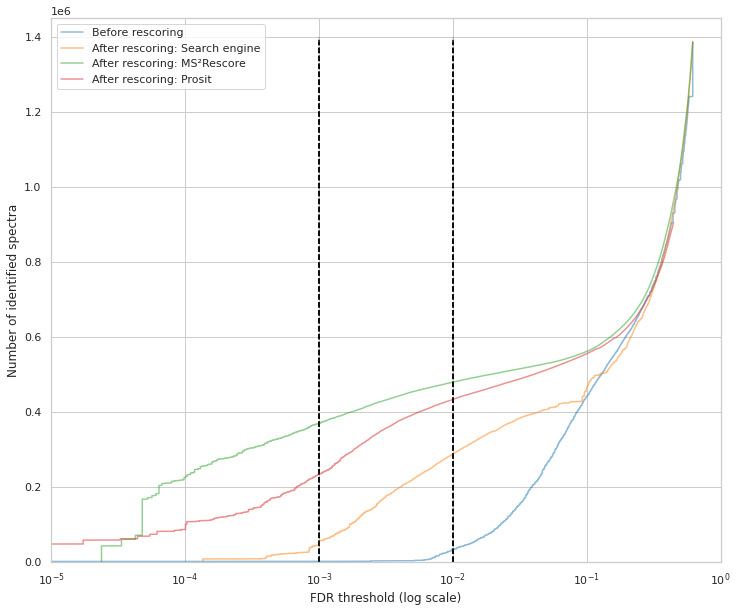

In [6]:
sns.set_style(style="whitegrid")
ax = plotting.RescoreRecord.qvalue_comparison()
ax.set_ylim(0,1450000)
ax.vlines([0.01, 0.001],ymin=0,ymax=1400000, colors="black", linestyles="dashed")
plt.savefig("data/Figures/FigureS4A.svg")
plt.show()

In [7]:
plotting.RescoreRecord._count_identifications([0.001, 0.01])
plotting.RescoreRecord._separate_unique_peptides(FDR_threshold=[0.001, 0.01])
plotting.RescoreRecord.calculate_loss_gain_df(FDR_threshold=[0.001,0.01], reference="After rescoring: Search engine")

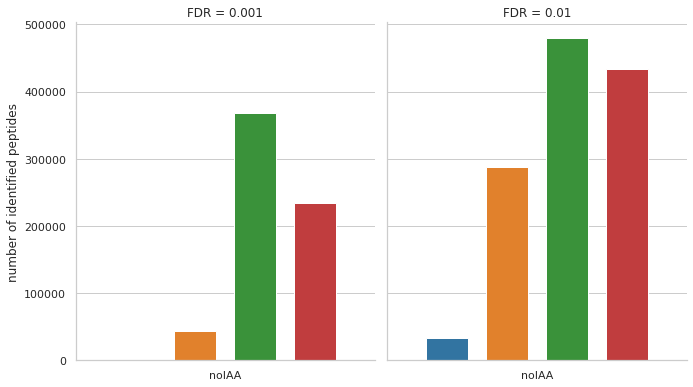

In [8]:
sns.set_style("whitegrid")
g = plotting.RescoreRecord.count_plot()
for ax in g.axes[0]:
    change_width(ax, 0.14)
g.fig.set_size_inches(13, 6)
g._legend.remove()
#plt.legend(title='',bbox_to_anchor=(-0.53,1))
plt.show()

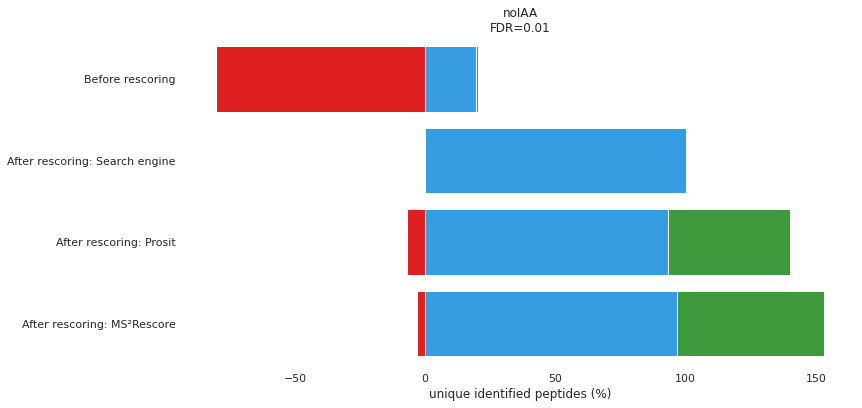

In [9]:
sns.set_style("whitegrid")
plotting.RescoreRecord.loss_gain_plot(FDR=0.01)
plt.show()


In [10]:
original_pin = pin.df
original_ms2rescore = ms2rescore.df
original_searchengine = searchengine.df

In [11]:
# keep prosit ids only
prosit_ids = []
for psmid in prosit.df.PSMId:
    match = re.search(r"(^[\w]*)[-]([0-9]*)", psmid)
    prosit_ids.append(f"{match.group(1)}.{match.group(2)}.{match.group(2)}")

pin.df = pin.df[pin.df["PSMId"].isin(prosit_ids)]
ms2rescore.df = ms2rescore.df[ms2rescore.df["PSMId"].isin(prosit_ids)]
searchengine.df = searchengine.df[searchengine.df["PSMId"].isin(prosit_ids)]

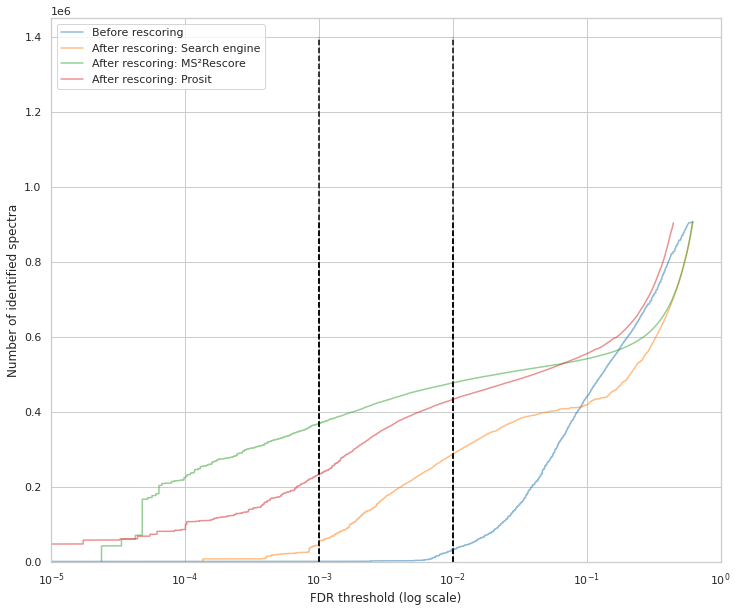

In [12]:
sns.set_style(style="whitegrid")
ax = plotting.RescoreRecord.qvalue_comparison()
ax.set_ylim(0,1450000)
ax.vlines([0.01, 0.001],ymin=0,ymax=1400000, colors="black", linestyles="dashed")
plt.legend(loc="upper left")
plt.savefig("data/Figures/FigureS4C.svg")
#ax.get_legend().remove()

In [13]:
pin.df = original_pin
ms2rescore.df = original_ms2rescore
searchengine.df = original_searchengine

# IAA

In [14]:
path_IAA = "data/PXD021398/output_IAA/"
plotting.RescoreRecord.empty_rerecs()
pin_A = plotting.PIN(path_IAA+"msms_IAA_searchengine_ms2pip_rt_features.pin", sample_name="IAA", score_metric="RawScore")
searchengine_A = plotting.POUT(path_IAA+"msms_IAA_searchengine_features.pout",path_IAA+"msms_IAA_searchengine_features.pout_dec", rescoring_features="Search engine", sample_name="IAA")
ms2rescore_A = plotting.POUT(path_IAA+"msms_IAA_searchengine_ms2pip_rt_features.pout",path_IAA+"msms_IAA_searchengine_ms2pip_rt_features.pout_dec", rescoring_features="MS²Rescore", sample_name="IAA")
prosit_A = plotting.POUT(path_IAA+"prosit_target_IAA.psms", path_IAA+"prosit_decoy_IAA.psms", rescoring_features="Prosit", sample_name="IAA")
prosit_A.df["peptide"] = prosit_A.df["peptide"].str.extract(r"_.([A-Z]*)._")


In [15]:
id_list_IAA = list(ms2rescore_A.df["PSMId"][(ms2rescore_A.df["q"] < 0.01)])
len(id_list_IAA)

1575308

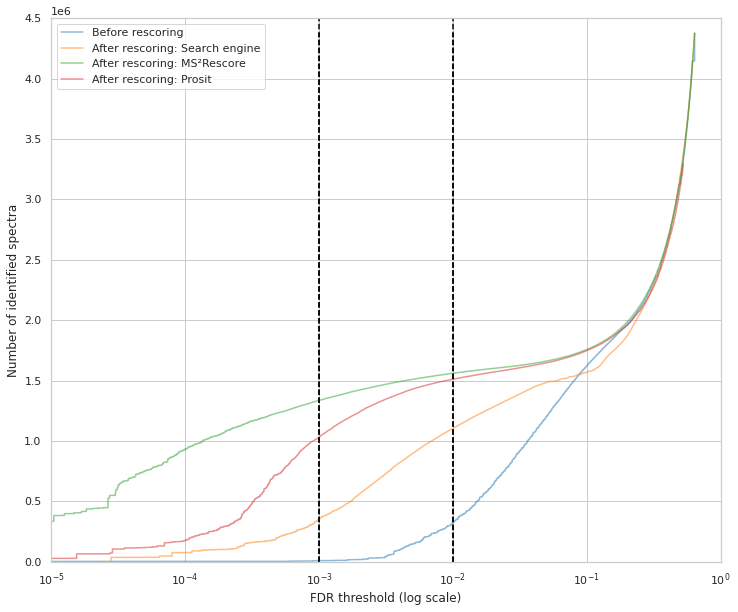

In [16]:
sns.set_style(style="whitegrid")
ax = plotting.RescoreRecord.qvalue_comparison()
ax.set_ylim(0,4500000)
ax.vlines([0.01, 0.001],ymin=0,ymax=4500000, colors="black", linestyles="dashed")
plt.savefig("data/Figures/FigureS4B.svg")
#ax.get_legend().remove()

In [17]:
plotting.RescoreRecord._count_identifications([0.001, 0.01])
plotting.RescoreRecord._separate_unique_peptides(FDR_threshold=[0.001, 0.01])
plotting.RescoreRecord.calculate_loss_gain_df(FDR_threshold=[0.001,0.01], reference="After rescoring: Search engine")

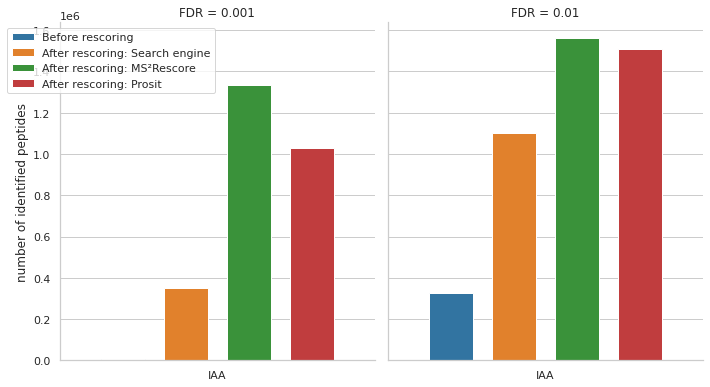

In [18]:
sns.set_style("whitegrid")
g = plotting.RescoreRecord.count_plot()
for ax in g.axes[0]:
    change_width(ax, 0.14)
g.fig.set_size_inches(13, 6)
g._legend.remove()
plt.legend(title='',bbox_to_anchor=(-0.53,1))

In [19]:
original_pin = pin_A.df
original_ms2rescore = ms2rescore_A.df
original_searchengine = searchengine_A.df

In [20]:
prosit_ids = []
for psmid in prosit_A.df.PSMId:
    match = re.search(r"(^[\w]*)[-]([0-9]*)", psmid)
    prosit_ids.append(f"{match.group(1)}.{match.group(2)}.{match.group(2)}")

pin_A.df = pin_A.df[pin_A.df["PSMId"].isin(prosit_ids)]
ms2rescore_A.df = ms2rescore_A.df[ms2rescore_A.df["PSMId"].isin(prosit_ids)]
searchengine_A.df = searchengine_A.df[searchengine_A.df["PSMId"].isin(prosit_ids)]

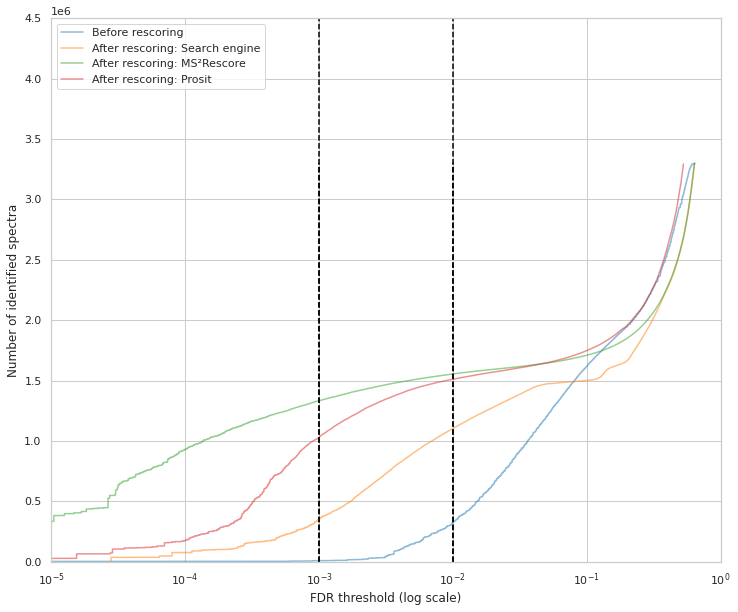

In [21]:
sns.set_style(style="whitegrid")
ax = plotting.RescoreRecord.qvalue_comparison()
ax.set_ylim(0,4500000)
ax.vlines([0.01, 0.001],ymin=0,ymax=4500000, colors="black", linestyles="dashed")
plt.legend(loc="upper left")
plt.savefig("data/Figures/FigureS4D.svg")
#ax.get_legend().remove()

In [22]:
pin_A.df = original_pin
ms2rescore_A.df = original_ms2rescore
searchengine_A.df = original_searchengine

# Combination IAA & noIAA

In [23]:
"""from immuno_ms2rescore_tools import file_utilities

mgf_files = file_utilities.MascotGenericFormat("data/mgf")
mgf_files.count_spectra(verbose=False)"""

'from immuno_ms2rescore_tools import file_utilities\n\nmgf_files = file_utilities.MascotGenericFormat("data/mgf")\nmgf_files.count_spectra(verbose=False)'

In [24]:
plotting.RescoreRecord.show_rerec_items()

Sample name: IAA
Type: pin
Rescore status: Before rescoring
Sample name: IAA
Type: pout
Rescore status: After rescoring: Search engine
Sample name: IAA
Type: pout
Rescore status: After rescoring: MS²Rescore
Sample name: IAA
Type: pout
Rescore status: After rescoring: Prosit


In [25]:
pin_A.df = pd.concat([pin.df, pin_A.df])
searchengine_A.df = pd.concat([searchengine.df, searchengine_A.df])
ms2rescore_A.df = pd.concat([ms2rescore.df, ms2rescore_A.df])
prosit_A.df = pd.concat([prosit.df, prosit_A.df])


In [26]:
plotting.RescoreRecord._count_identifications([0.001, 0.01])
plotting.RescoreRecord._separate_unique_peptides(FDR_threshold=[0.001, 0.01])
plotting.RescoreRecord.calculate_loss_gain_df(FDR_threshold=[0.001,0.01],reference="After rescoring: Search engine")

In [27]:
plotting.RescoreRecord.count_df["count"] = (plotting.RescoreRecord.count_df["count"]/18375659) * 100

In [28]:
plotting.RescoreRecord.count_df

,sample,rescoring,count,FDR
0,IAA,Before rescoring,0.048287,0.001
1,IAA,Before rescoring,1.948621,0.010
2,IAA,After rescoring: Search engine,2.153038,0.001
3,IAA,After rescoring: Search engine,7.570346,0.010
4,IAA,After rescoring: MS²Rescore,9.272886,0.001
5,IAA,After rescoring: MS²Rescore,11.094530,0.010
6,IAA,After rescoring: Prosit,6.869648,0.001
7,IAA,After rescoring: Prosit,10.574043,0.010


In [29]:
plotting.RescoreRecord.unique_df

,sample,rescoring,upeps,FDR,count
0,IAA,Before rescoring,"[FDGALNVDLTEFQTNLVPYPR, HSTIFENLANK, VVSVLTVLH...",0.001,2661
1,IAA,Before rescoring,"[FDGALNVDLTEFQTNLVPYPR, HSTIFENLANK, VVSVLTVLH...",0.010,53769
2,IAA,After rescoring: Search engine,"[FDGALNVDLTEFQTNLVPYPR, HSTIFENLANK, VVSVLTVLH...",0.001,54263
3,IAA,After rescoring: Search engine,"[FDGALNVDLTEFQTNLVPYPR, HSTIFENLANK, VVSVLTVLH...",0.010,141604
4,IAA,After rescoring: MS²Rescore,"[FDGALNVDLTEFQTNLVPYPR, TLVLSNLSYSATEETLQEVFEK...",0.001,161707
5,IAA,After rescoring: MS²Rescore,"[FDGALNVDLTEFQTNLVPYPR, TLVLSNLSYSATEETLQEVFEK...",0.010,192882
6,IAA,After rescoring: Prosit,"[LHHVSSLAWLDEHTLVTTSHDASVK, VIHDNFGIVEGLMTTVHA...",0.001,131029
7,IAA,After rescoring: Prosit,"[LHHVSSLAWLDEHTLVTTSHDASVK, VIHDNFGIVEGLMTTVHA...",0.010,182430


17728 37822


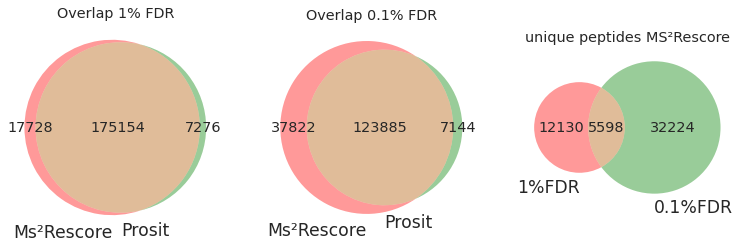

In [89]:
sns.set_style("whitegrid")


fig = plt.Figure(figsize=(13,22))
ax1 = fig.add_subplot(131)
upeps_ms2rescore_1 = set(plotting.RescoreRecord.unique_df.at[5, 'upeps'])
upeps_prosit_1 = set(plotting.RescoreRecord.unique_df.at[7, 'upeps'])
difference_1 = upeps_ms2rescore_1 - upeps_prosit_1
venn2(subsets=[upeps_ms2rescore_1,upeps_prosit_1],set_labels=["Ms²Rescore", "Prosit"], ax=ax1)
ax1.set_title("Overlap 1% FDR")
ax2 = fig.add_subplot(132)
upeps_ms2rescore_01 = set(plotting.RescoreRecord.unique_df.at[4, 'upeps'])
upeps_prosit_01 = set(plotting.RescoreRecord.unique_df.at[6, 'upeps'])
difference_01 = upeps_ms2rescore_01 - upeps_prosit_01
venn2(subsets=[upeps_ms2rescore_01,upeps_prosit_01],set_labels=["Ms²Rescore", "Prosit"], ax=ax2)
ax2.set_title("Overlap 0.1% FDR")
ax3 = fig.add_subplot(133)

venn2(subsets=[difference_1,difference_01],set_labels=["1%FDR", "0.1%FDR"], ax=ax3)
ax3.set_title("unique peptides MS²Rescore")

print(len(difference_1), len(difference_01))

fig

In [30]:
plotting.RescoreRecord.loss_gain_df

,sample,feature,FDR,shared,gain,loss
0,IAA,Before rescoring,0.001,4.806222,4.903894,-95.193778
1,IAA,After rescoring: Search engine,0.001,100.000000,100.000000,-0.000000
2,IAA,After rescoring: MS²Rescore,0.001,99.432394,298.006008,-0.567606
3,IAA,After rescoring: Prosit,0.001,94.500857,241.470247,-5.499143
4,IAA,Before rescoring,0.010,36.974238,37.971385,-63.025762
5,IAA,After rescoring: Search engine,0.010,100.000000,100.000000,-0.000000
6,IAA,After rescoring: MS²Rescore,0.010,96.697127,136.212254,-3.302873
7,IAA,After rescoring: Prosit,0.010,94.692240,128.831106,-5.307760


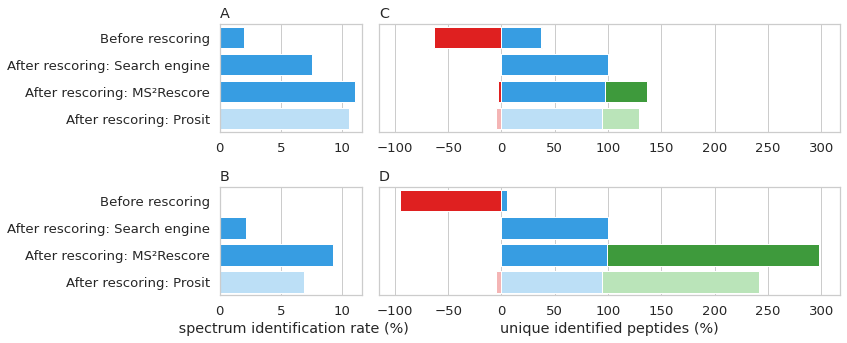

In [31]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
fig = plt.Figure(figsize=(12,5))

ax1 = plt.subplot2grid((2,4),(0,0), colspan=1, fig=fig)
sns.barplot(
    x="count",
    y="rescoring",
    data=plotting.RescoreRecord.count_df[plotting.RescoreRecord.count_df["FDR"]== 0.01],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax1
)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("A",loc="left")
ax2 = plt.subplot2grid((2,4),(0,1),colspan=3, fig=fig)
sns.barplot(
    y="feature",
    x="gain",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.01],
    palette=sns.color_palette(["#2FA92D","#2FA92D","#2FA92D","#B3EBB2"]),
    ax=ax2,
)
sns.barplot(
    y="feature",
    x="shared",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.01],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax2,
)
sns.barplot(
    y="feature",
    x="loss",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.01],
    palette=sns.color_palette(["#FF0000","#FF0000","#FF0000","#FFABAB"]),
    ax=ax2,
)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_yticklabels([])
ax2.set_title("C",loc="left")

ax3 = plt.subplot2grid((2,4),(1,0),colspan=1, fig=fig, sharex=ax1)
sns.barplot(
    x="count",
    y="rescoring",
    data=plotting.RescoreRecord.count_df[plotting.RescoreRecord.count_df["FDR"]== 0.001],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax3
)
ax3.set_ylabel("")
ax3.set_xlabel(" spectrum identification rate (%)")
ax3.set_title("B",loc="left")

ax4 = plt.subplot2grid((2,4),(1,1),colspan=3, fig=fig, sharex=ax2)
sns.barplot(
    y="feature",
    x="gain",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.001],
    palette=sns.color_palette(["#2FA92D","#2FA92D","#2FA92D","#B3EBB2"]),
    ax=ax4,
)
sns.barplot(
    y="feature",
    x="shared",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.001],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax4,
)
sns.barplot(
    y="feature",
    x="loss",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.001],
    palette=sns.color_palette(["#FF0000","#FF0000","#FF0000","#FFABAB"]),
    ax=ax4,
)
ax4.set_ylabel("")
ax4.set_xlabel("unique identified peptides (%)")
ax4.set_yticklabels([])
ax4.set_title("D",loc="left")
fig.tight_layout(rect=[0, 0, 1, 1])
fig.savefig("data/Figures/Figure2.svg")
fig


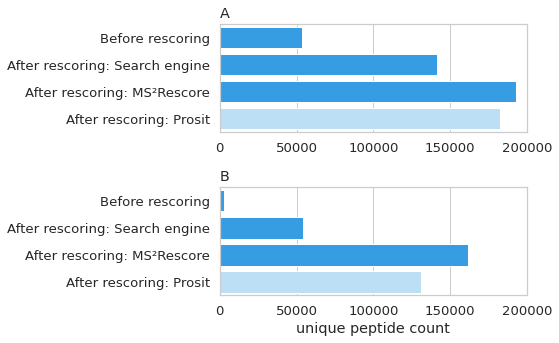

In [32]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
fig = plt.Figure(figsize=(8,5))

ax1 = plt.subplot2grid((2,1),(0,0), colspan=1, fig=fig)
sns.barplot(
    x="count",
    y="rescoring",
    data=plotting.RescoreRecord.unique_df[plotting.RescoreRecord.unique_df["FDR"]== 0.01],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax1
)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("A",loc="left")
ax1.set_xlim(0,200000)
ax3 = plt.subplot2grid((2,1),(1,0),colspan=1, fig=fig, sharex=ax1)
sns.barplot(
    x="count",
    y="rescoring",
    data=plotting.RescoreRecord.unique_df[plotting.RescoreRecord.unique_df["FDR"]== 0.001],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax3
)
ax3.set_ylabel("")
ax3.set_xlabel("unique peptide count")
ax3.set_title("B",loc="left")
fig.tight_layout()
fig.savefig("data/Figures/FigureS3.svg")
fig

# Weights analysis

In [49]:
weights_IAA = pd.read_table("data/PXD021398/output_IAA/msms_IAA_searchengine_ms2pip_rt_features.weights", sep="\t")
weights_IAA.drop([1,2,4,5,7], axis=0, inplace=True)
weights_IAA.drop("m0", axis=1, inplace=True)

weights_noIAA = pd.read_table("data/PXD021398/output_noIAA/msms_noIAA_searchengine_ms2pip_rt_features.weights", sep="\t")
weights_noIAA.drop([1,2,4,5,7], axis=0, inplace=True)
weights_noIAA.drop("m0", axis=1, inplace=True)


In [34]:
weights_IAA = weights_IAA.astype(float)
weights_IAA.loc["mean"] = weights_IAA.mean()

weights_noIAA = weights_noIAA.astype(float)
weights_noIAA.loc["mean"] = weights_noIAA.mean()


In [35]:
reindex_list = []
reindex_list.extend(weights_IAA.iloc[3, :71].abs().sort_values(ascending=True).index)
reindex_list.extend(weights_IAA.iloc[3, 71:77].abs().sort_values(ascending=True).index)
reindex_list.extend(weights_IAA.iloc[3, 77:].abs().sort_values(ascending=True).index)


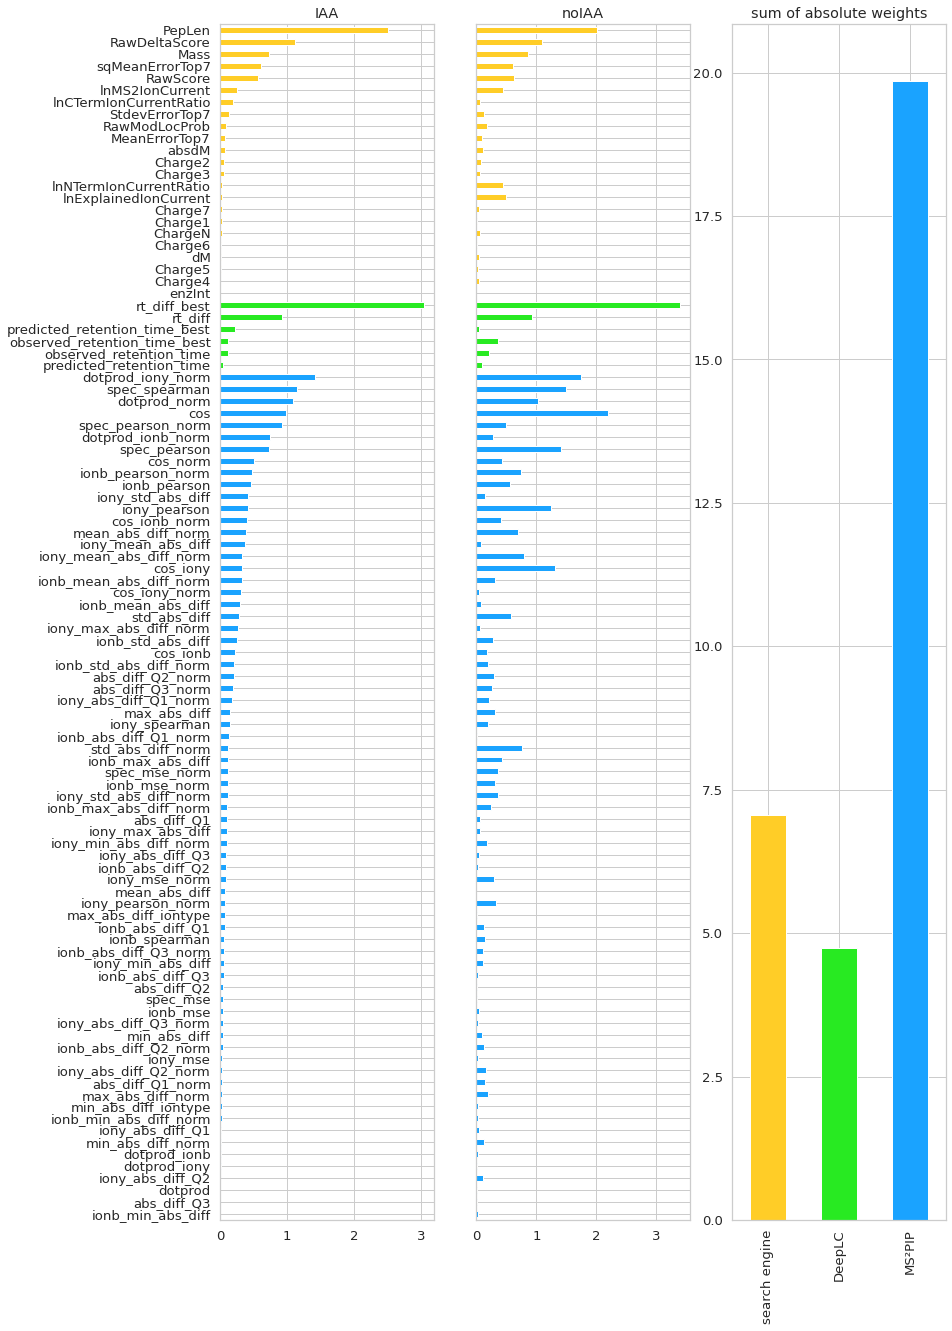

In [36]:
sns.set_style("whitegrid")
feature_cmap = ["#1AA3FF"] * 71 + ["#28ea22"] * 6 + ["#FFCD27"] * 24
col_iterator = zip(list(weights_IAA.columns), feature_cmap)
color_map = dict(col_iterator)

fig = plt.Figure(figsize=(13,22))
ax1 = fig.add_subplot(131)
rowIAA = weights_IAA.iloc[3].abs().reindex(reindex_list)
feature_cmap = [color_map[k] for k in rowIAA.index]
rowIAA.plot(kind="barh", ax=ax1, color=feature_cmap)
ax1.set_title("IAA")
ax2 = fig.add_subplot(132, sharey=ax1)
rownoIAA = weights_noIAA.iloc[3].abs().reindex(reindex_list)
rownoIAA.plot(kind="barh", ax=ax2, color=feature_cmap)
ax2.set_title("noIAA")
ax3 = fig.add_subplot(133)
weight_sum = pd.Series(index=["MS²PIP", "DeepLC", "search engine"], dtype=float)
weight_sum["MS²PIP"] = (sum(weights_IAA.iloc[3, :71].abs()) + sum(weights_noIAA.iloc[3, :71].abs()))/2
weight_sum["DeepLC"] = (sum(weights_IAA.iloc[3, 71:77].abs()) + sum(weights_noIAA.iloc[3, 71:77].abs()))/2
weight_sum["search engine"] = (sum(weights_IAA.iloc[3, 77:].abs()) + sum(weights_noIAA.iloc[3, 77:].abs()))/2
weight_sum_reindexed = weight_sum.reindex(["search engine", "DeepLC", "MS²PIP"])
weight_sum_reindexed.plot(kind="bar", ax=ax3, color=["#FFCD27", "#28ea22","#1AA3FF" ])
ax3.set_title("sum of absolute weights")
fig.savefig("data/Figures/FigureS2.svg")
fig

In [69]:
prosit_weights_IAA = pd.read_table("data/PXD021398/output_IAA/prosit_weights_IAA.csv", sep="\t")
prosit_weights_IAA.drop([1,2,4,5,7], axis=0, inplace=True)
prosit_weights_IAA.drop("m0", axis=1, inplace=True)

prosit_weights_noIAA = pd.read_table("data/PXD021398/output_noIAA/prosit_weights_noIAA.csv", sep="\t")
prosit_weights_noIAA.drop([1,2,4,5,7], axis=0, inplace=True)
prosit_weights_noIAA.drop("m0", axis=1, inplace=True)

In [70]:
prosit_weights_IAA = prosit_weights_IAA.astype(float)
prosit_weights_IAA.loc["mean"] = prosit_weights_IAA.mean()

prosit_weights_noIAA = prosit_weights_noIAA.astype(float)
prosit_weights_noIAA.loc["mean"] = prosit_weights_noIAA.mean()


In [71]:
reindex_list = []
reindex_list.extend(prosit_weights_IAA.iloc[3, :].abs().sort_values(ascending=True).index)

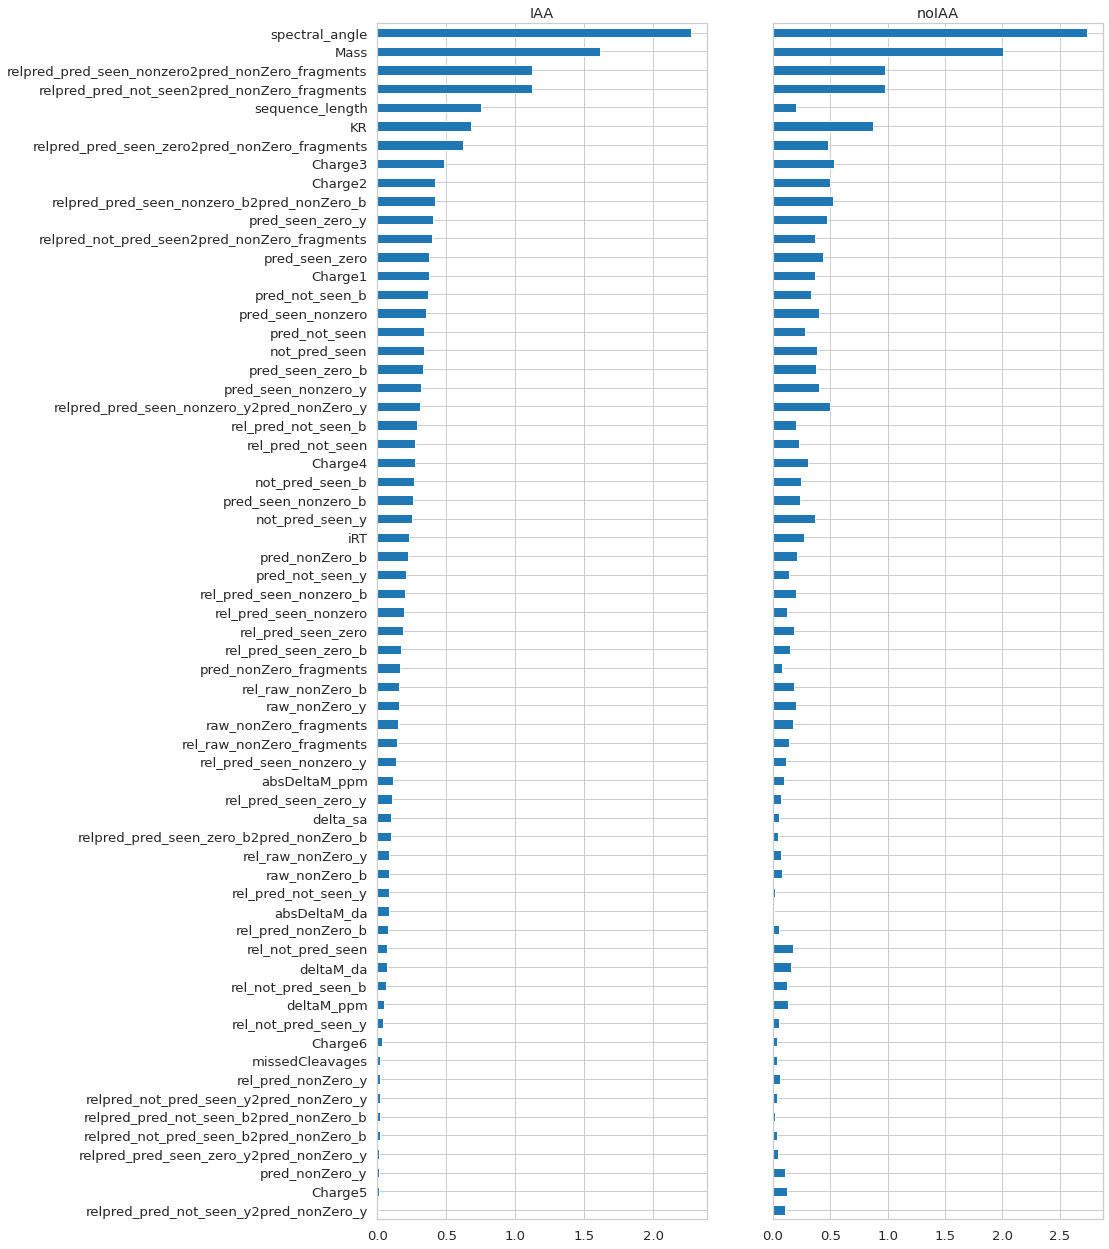

In [73]:
sns.set_style("whitegrid")

fig = plt.Figure(figsize=(13,22))
ax1 = fig.add_subplot(121)
rowIAA = prosit_weights_IAA.iloc[3].abs().reindex(reindex_list)
rowIAA.plot(kind="barh", ax=ax1)
ax1.set_title("IAA")
ax2 = fig.add_subplot(122, sharey=ax1)
rownoIAA = prosit_weights_noIAA.iloc[3].abs().reindex(reindex_list)
rownoIAA.plot(kind="barh", ax=ax2)
ax2.set_title("noIAA")
fig

# MS²PIP correlations & DeepLC correlations

In [37]:
pin_noIAA = PercolatorIn("data/PXD021398/output_noIAA/msms_noIAA_searchengine_ms2pip_rt_features.pin")
pin_noIAA.df["Label"] = ["decoy" if x==-1 else "rejected target" for x in pin_noIAA.df["Label"]]
pin_noIAA.df.loc[pin_noIAA.df.SpecId.isin(id_list_noIAA), "Label"] = "accepted target"

pin_IAA = PercolatorIn("data/PXD021398/output_IAA/msms_IAA_searchengine_ms2pip_rt_features.pin")
pin_IAA.df["Label"] = ["decoy" if x==-1 else "rejected target" for x in pin_IAA.df["Label"]]
pin_IAA.df.loc[pin_IAA.df.SpecId.isin(id_list_IAA), "Label"] = "accepted target"



In [38]:
pin = pd.concat([pin_IAA.df, pin_noIAA.df]).reset_index()
pin.drop("index", axis=1, inplace=True)

In [39]:
chunks = []
chunksize = 10 ** 6
with pd.read_table("data/PXD021398/msms_full.txt", chunksize=chunksize,usecols=["Raw file", "Scan number", "Modifications"]) as reader:
    for parts in reader:
        chunks.append(parts)
msms = pd.concat(chunks)


In [40]:
msms["SpecId"] = msms["Raw file"] +"." + msms["Scan number"].astype(str) +"." + msms["Scan number"].astype(str)


In [41]:
pin2 = pin.merge(msms[["SpecId", "Modifications", "Raw file"]], on="SpecId", how="inner")


In [42]:
pin2.rename({"rt_diff_best": "rt_diff_best_abs"}, axis=1, inplace=True)

In [43]:
pin2.drop(["rt_diff", "observed_retention_time_best", "predicted_retention_time_best"], inplace=True, axis=1)
pin2["rt_diff"] = pin2["observed_retention_time"] - pin2["predicted_retention_time"]
min_rt_diff = pin2[["Peptide", "Modifications","rt_diff", "observed_retention_time", "predicted_retention_time"]].copy()
min_rt_diff = (
            min_rt_diff.sort_values("rt_diff", ascending=True)
            .drop_duplicates(subset=["Peptide", "Modifications"], keep="first")
            .rename(
                columns={
                    "rt_diff": "rt_diff_best",
                    "observed_retention_time": "observed_retention_time_best",
                    "predicted_retention_time": "predicted_retention_time_best",
                }
            )
        )
pin2 = pin2.merge(min_rt_diff, on=["Peptide", "Modifications"], how="left") 

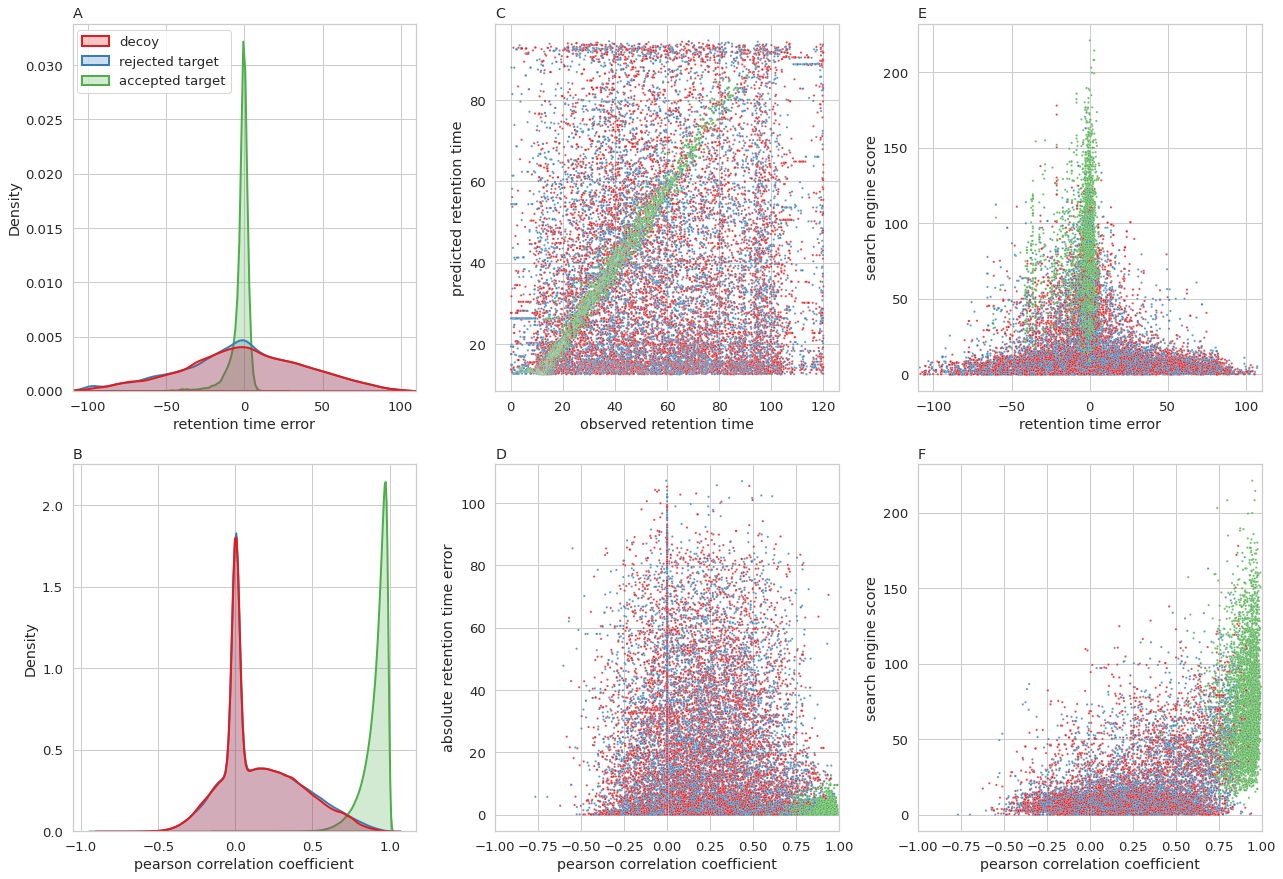

In [44]:
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")
fig = plt.Figure(figsize=(18,18))

ax1 = fig.add_subplot(331)
sns.kdeplot(
    x="rt_diff_best", 
    data=pin2,
    hue="Label",
    shade=True,
    ax=ax1,
    hue_order=["decoy", "rejected target", "accepted target"],
    palette="Set1",
    common_norm=True, 
    linewidth=2, 
    bw_adjust=2,
    )
ax1.get_legend().set_bbox_to_anchor((0.48,1))
ax1.get_legend().set_title("")
ax1.set_title("A", loc="left")
ax1.set_xlim(-110,110)
ax1.set_xlabel("retention time error")


ax2 = fig.add_subplot(332)
sns.scatterplot(
    x="observed_retention_time",
    y="predicted_retention_time", 
    hue="Label",
    data=pin2[pin2.SpecId.str.contains("GN20170531_SK_HLA_C0102_R1_01")],
    palette="Set1", 
    hue_order=["decoy", "rejected target", "accepted target"],
    legend=False,
    ax=ax2,
    alpha=0.8,
    s=5
)
ax2.set_title("C", loc="left")
ax2.set_xlabel("observed retention time")
ax2.set_ylabel("predicted retention time")


ax3 = fig.add_subplot(333)
sns.scatterplot(
    x="rt_diff_best",
    y="RawScore", 
    hue="Label",
    data=pin2[pin2.SpecId.str.contains("GN20170531_SK_HLA_C0102_R1_01")],
    palette="Set1", 
    hue_order=["decoy", "rejected target", "accepted target"],
    legend=False,
    ax=ax3,
    alpha=0.8,
    s=5
)
ax3.set_title("E", loc="left")
ax3.set_xlim(-110,110)
ax3.set_xlabel("retention time error")
ax3.set_ylabel("search engine score")


ax4 = fig.add_subplot(334)
sns.kdeplot(
    x="spec_pearson_norm", 
    data=pin2,
    hue="Label",
    shade=True,
    ax=ax4,
    hue_order=["decoy", "rejected target", "accepted target"],
    palette="Set1",
    common_norm=True, 
    linewidth=2, 
    bw_adjust=2,
    legend=False
    )
ax4.set_title("B", loc="left")
ax4.set_xlabel("pearson correlation coefficient")


ax5 = fig.add_subplot(335)
sns.scatterplot(
    x="spec_pearson_norm",
    y="rt_diff_best_abs", 
    hue="Label",
    data=pin2[pin2.SpecId.str.contains("GN20170531_SK_HLA_C0102_R1_01")],
    palette="Set1", 
    hue_order=["decoy", "rejected target", "accepted target"],
    legend=False,
    ax=ax5,
    alpha=0.8,
    s=5
)
ax5.set_title("D", loc="left")
ax5.set_xlim(-1,1)
ax5.set_xlabel("pearson correlation coefficient")
ax5.set_ylabel("absolute retention time error")

ax6 = fig.add_subplot(336)
sns.scatterplot(
    x="spec_pearson_norm",
    y="RawScore", 
    hue="Label",
    data=pin2[pin2.SpecId.str.contains("GN20170531_SK_HLA_C0102_R1_01")],
    palette="Set1", 
    hue_order=["decoy", "rejected target", "accepted target"],
    legend=False,
    ax=ax6,
    alpha=0.8,
    s=5
)
ax6.set_title("F", loc="left")
ax6.set_xlabel("pearson correlation coefficient")
ax6.set_ylabel("search engine score")
ax6.set_xlim(-1,1)

fig.tight_layout()
fig.savefig("data/Figures/Figure3.svg")
fig

In [45]:
pin2["peptide type"] = ["tryptic" if (x[-1] == "R") | (x[-1] == "K") else "non tryptic" for x in pin2.Peptide]

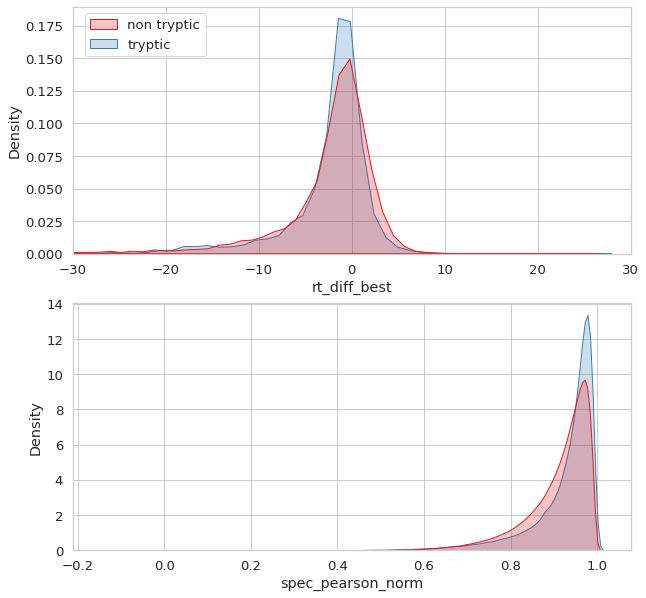

In [46]:
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")
fig = plt.Figure(figsize=(10,10))

ax1 = fig.add_subplot(211)
sns.kdeplot(
    x="rt_diff_best", 
    data=pin2[pin2.Label == "accepted target"],
    hue="peptide type",
    shade=True,
    ax=ax1,
    palette="Set1",
    common_norm=False
    )
ax1.get_legend().set_bbox_to_anchor((0.25,1))
ax1.get_legend().set_title("")
ax1.set_xlim(-30,30)

ax2 = fig.add_subplot(212)
sns.kdeplot(
    x="spec_pearson_norm", 
    data=pin2[pin2.Label == "accepted target"],
    hue="peptide type",
    shade=True,
    ax=ax2,
    palette="Set1",
    common_norm=False
    )
ax2.get_legend().remove()

fig